## **Binning Concept (Encoding Numerical Features)**

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

In [3]:
data = pd.read_csv('/content/train.csv', usecols=['Age', 'Fare', 'Survived'])

In [4]:
data.sample(10)

,Survived,Age,Fare
695,0,52.0,13.5000
511,0,NaN,8.0500
795,0,39.0,13.0000
128,1,NaN,22.3583
712,1,48.0,52.0000
328,1,31.0,20.5250
620,0,27.0,14.4542
247,1,24.0,14.5000
188,0,40.0,15.5000
329,1,16.0,57.9792


In [5]:
data.dropna(inplace=True)

In [6]:
data.shape

(714, 3)

In [7]:
data.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [9]:
X = data.iloc[:,1:]
y = data.iloc[:,0]

In [10]:
X

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500
...,...,...
885,39.0,29.1250
886,27.0,13.0000
887,19.0,30.0000
889,26.0,30.0000


In [11]:
y

0      0
1      1
2      1
3      1
4      0
      ..
885    0
886    0
887    1
889    1
890    0
Name: Survived, Length: 714, dtype: int64

In [12]:
#Train_test_split_method
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
X_train.sample(4), X_test.sample(4), y_train.sample(4), y_test.sample(4)

(      Age     Fare
 94   59.0   7.2500
 463  48.0  13.0000
 801  31.0  26.2500
 591  52.0  78.2667,
       Age     Fare
 207  26.0  18.7875
 590  35.0   7.1250
 136  19.0  26.2833
 369  24.0  69.3000,
 658    0
 38     0
 237    1
 641    1
 Name: Survived, dtype: int64,
 90     0
 443    1
 525    0
 416    1
 Name: Survived, dtype: int64)

### **Checking accuracy before applying Encoding**

In [15]:
clf = DecisionTreeClassifier()

In [16]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [17]:
accuracy_score(y_test,y_pred)

0.6223776223776224

In [18]:
np.mean(cross_val_score(DecisionTreeClassifier(),X,y,cv=10,scoring='accuracy'))

0.6289319248826291

### **Checking accuracy after applying K-means binning**

In [19]:
kbin_age = KBinsDiscretizer(n_bins=15,encode='ordinal',strategy='quantile')
kbin_fare = KBinsDiscretizer(n_bins=15,encode='ordinal',strategy='quantile')

In [20]:
trf = ColumnTransformer([
    ('first',kbin_age,[0]),
    ('second',kbin_fare,[1])
])

In [21]:
X_train_trf = trf.fit_transform(X_train)
X_test_trf = trf.transform(X_test)

In [22]:
trf.named_transformers_['first'].bin_edges_

array([array([ 0.42,  6.  , 16.  , 19.  , 21.  , 23.  , 25.  , 28.  , 30.  ,
              32.  , 35.  , 38.  , 42.  , 47.  , 54.  , 80.  ])             ],
      dtype=object)

In [23]:
output = pd.DataFrame({
    'age':X_train['Age'],
    'age_trf':X_train_trf[:,0],
    'fare':X_train['Fare'],
    'fare_trf':X_train_trf[:,1]
})

In [24]:
output['age_labels'] = pd.cut(x=X_train['Age'],
                                    bins=trf.named_transformers_['first'].bin_edges_[0].tolist())
output['fare_labels'] = pd.cut(x=X_train['Fare'],
                                    bins=trf.named_transformers_['second'].bin_edges_[0].tolist())

In [25]:
output.sample(5)

,age,age_trf,fare,fare_trf,age_labels,fare_labels
505,18.0,2.0,108.9000,13.0,"(16.0, 19.0]","(76.292, 108.9]"
789,46.0,12.0,79.2000,13.0,"(42.0, 47.0]","(76.292, 108.9]"
10,4.0,0.0,16.7000,7.0,"(0.42, 6.0]","(14.454, 18.75]"
291,19.0,3.0,91.0792,13.0,"(16.0, 19.0]","(76.292, 108.9]"
675,18.0,2.0,7.7750,2.0,"(16.0, 19.0]","(7.25, 7.775]"


In [26]:
clf = DecisionTreeClassifier()
clf.fit(X_train_trf,y_train)
y_pred2 = clf.predict(X_test_trf)

In [27]:
accuracy_score(y_test,y_pred2)

0.6363636363636364

In [28]:
X_trf = trf.fit_transform(X)
np.mean(cross_val_score(DecisionTreeClassifier(),X,y,cv=10,scoring='accuracy'))

0.6344874804381846

In [29]:
def discretize(bins,strategy):
    kbin_age = KBinsDiscretizer(n_bins=bins,encode='ordinal',strategy=strategy)
    kbin_fare = KBinsDiscretizer(n_bins=bins,encode='ordinal',strategy=strategy)

    trf = ColumnTransformer([
        ('first',kbin_age,[0]),
        ('second',kbin_fare,[1])
    ])

    X_trf = trf.fit_transform(X)
    print(np.mean(cross_val_score(DecisionTreeClassifier(),X,y,cv=10,scoring='accuracy')))

    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.hist(X['Age'])
    plt.title("Before")

    plt.subplot(122)
    plt.hist(X_trf[:,0],color='red')
    plt.title("After")

    plt.show()

    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.hist(X['Fare'])
    plt.title("Before")

    plt.subplot(122)
    plt.hist(X_trf[:,1],color='red')
    plt.title("Fare")

    plt.show()

0.6316705790297339


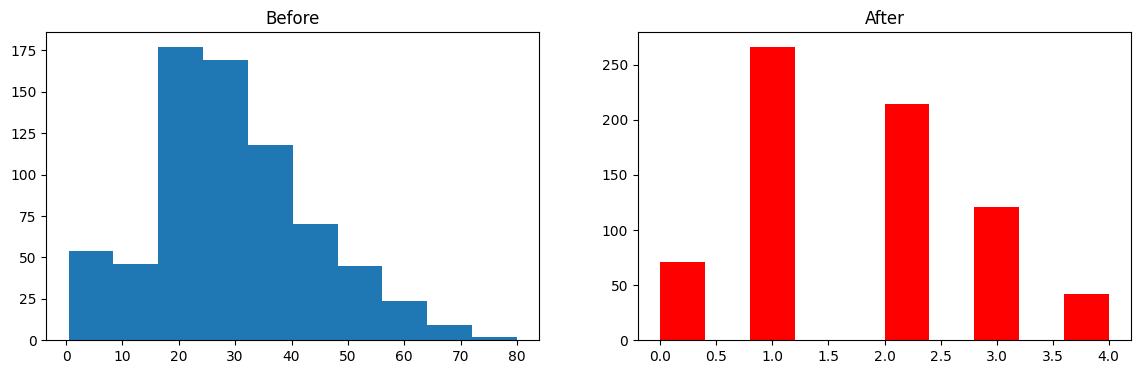

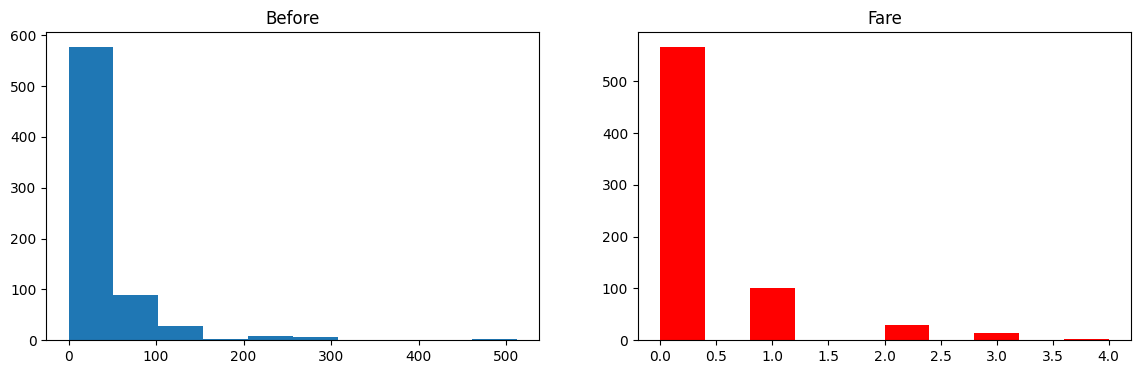

In [30]:
discretize(5,'kmeans')

0.630281690140845


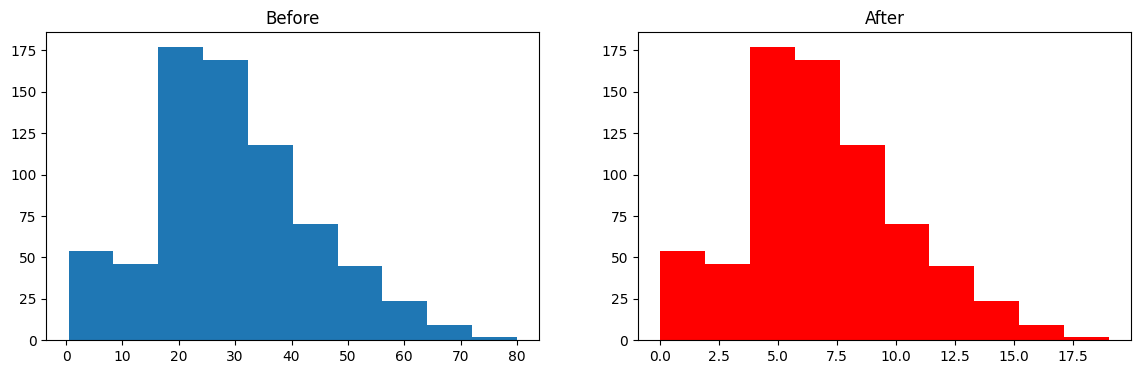

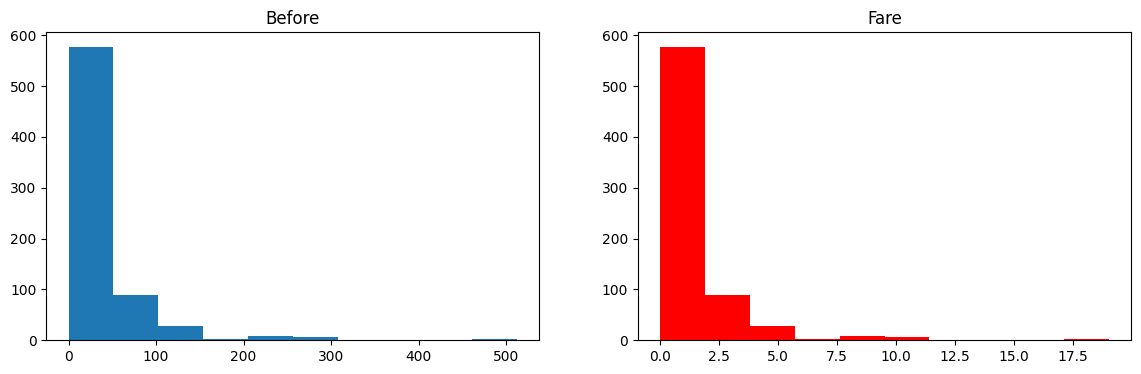

In [31]:
discretize(20, 'uniform')

0.6261150234741784


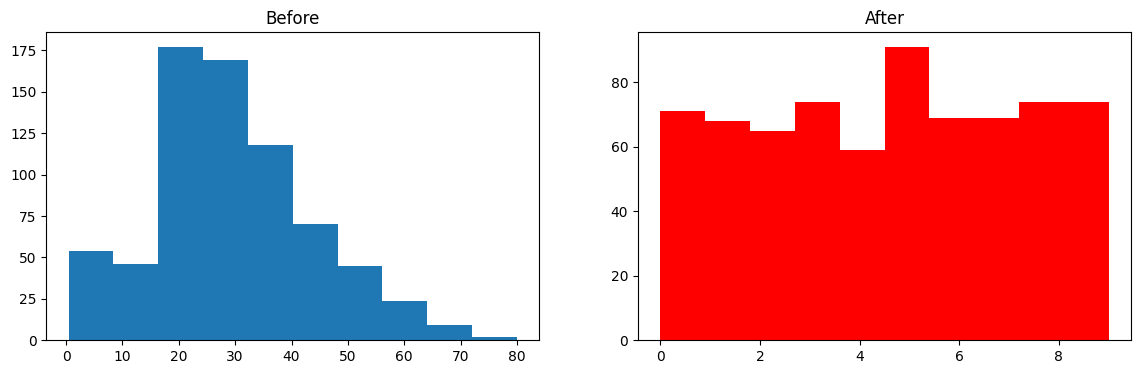

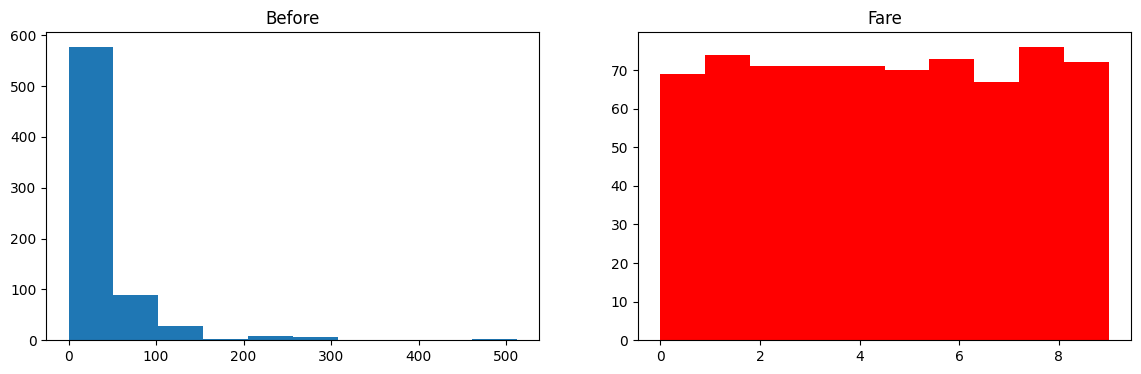

In [32]:
discretize(10,'quantile')